In [59]:
import numpy as np
import numpy
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
try:
    import csiborgtools
except ModuleNotFoundError:
    print("not found")
    import sys
    sys.path.append("../")
    import csiborgtools
# import utils
import joblib

from scipy.stats import spearmanr
from datetime import datetime

from tqdm import tqdm, trange
from numba import jit

from os.path import join
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
cat0 = csiborgtools.read.HaloCatalogue(7468)
catx = csiborgtools.read.HaloCatalogue(7588)

In [3]:
reader = csiborgtools.read.PairOverlap(cat0, catx, max_dist=150 / 0.705)

<IPython.core.display.Javascript object>


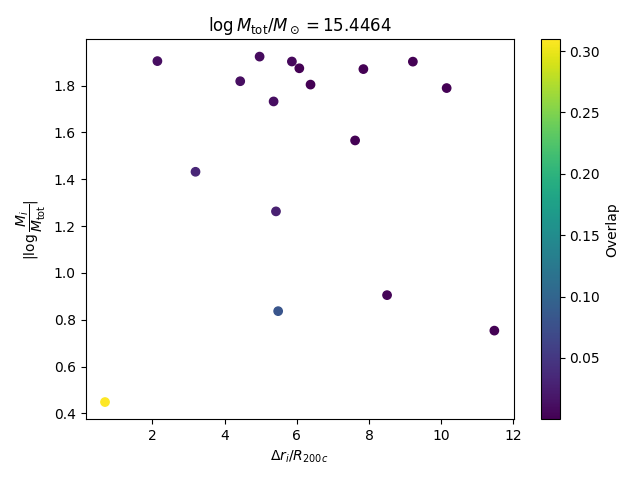

In [4]:
ks = np.argsort(reader.cat0("totpartmass"))[::-1]
k = ks[2]


plt.figure()
plt.scatter(reader.dist(False, "r200")[k], reader.mass_ratio()[k], c=reader["overlap"][k])
plt.colorbar(label="Overlap")

plt.title(r"$\log M_{{\rm tot}} / M_\odot = {:.4f}$".format(np.log10(reader.cat0("totpartmass")[k])))
plt.xlabel(r"$\Delta r_i / R_{200c}$")
plt.ylabel(r"$|\log \dfrac{M_i}{M_{\rm tot}}|$")
plt.tight_layout()
plt.show()

In [5]:
print("Starting: {}.".format(datetime.now()))
clumps0 = np.load("/mnt/extraspace/rstiskalek/csiborg/initmatch/clump_7468_particles.npy", allow_pickle=True)
print("Loaded `clump0`: {}.".format(datetime.now()))
clumpsx = np.load("/mnt/extraspace/rstiskalek/csiborg/initmatch/clump_7588_particles.npy", allow_pickle=True)
print("Loaded `clumpx`: {}.".format(datetime.now()))

overlapper = csiborgtools.match.ParticleOverlap()

hid2clumps0 = {hid: n for n, hid in enumerate(clumps0["ID"])}
hid2clumpsx = {hid: n for n, hid in enumerate(clumpsx["ID"])}

Starting: 2023-03-20 07:57:52.315875.
Loaded `clump0`: 2023-03-20 08:06:41.624058.
Loaded `clumpx`: 2023-03-20 08:13:58.343592.


In [6]:
# Convert positions to cell IDs
csiborgtools.read.clumps_pos2cell(clumps0, overlapper)
csiborgtools.read.clumps_pos2cell(clumpsx, overlapper)

mins0, maxs0 = csiborgtools.match.get_clumplims(clumps0, overlapper.inv_clength, overlapper.nshift)
minsx, maxsx = csiborgtools.match.get_clumplims(clumpsx, overlapper.inv_clength, overlapper.nshift)

In [7]:
delta_bckg0 = overlapper.make_bckg_delta(clumps0)
delta_bckgx = overlapper.make_bckg_delta(clumpsx)

In [8]:
smooth_kwargs = {"sigma": 1, "truncate": 4, "mode": "constant", "cval": 0.0}

delta_bckg0_smooth = overlapper.make_bckg_delta(clumps0, smooth_kwargs)
delta_bckgx_smooth = overlapper.make_bckg_delta(clumpsx, smooth_kwargs)

In [69]:
ks = np.argsort(reader.cat0("totpartmass"))[::-1]
k = ks[1]
# k = 107321
n = 0

print("Original overlap is ", reader["overlap"][k][n])
print("Smoothed overlap is ", reader["smoothed_overlap"][k][n])

index_cl0 = hid2clumps0[reader.cat0("index", k)]
cl0 = clumps0[index_cl0][0]
mins_cl0, maxs_cl0 = mins0[index_cl0], maxs0[index_cl0]

index_clx = hid2clumpsx[reader.catx("index", reader["match_indxs"][k][n])]
clx = clumpsx[index_clx][0]
mins_clx, maxs_clx = minsx[index_clx], maxsx[index_clx]



delta1, delta2, cellmins, nonzero1 = overlapper.make_deltas(
    cl0, clx, mins_cl0, maxs_cl0, mins_clx, maxs_clx)

m1 = np.sum(cl0["M"])
m2 = np.sum(clx["M"])


calculate_overlap(delta1, delta2, cellmins, delta_bckg0, delta_bckgx)

Original overlap is  0.6262465
Smoothed overlap is  0.86674386
0.9976725214820453 0.99849546370088
intersect  6.625882815569639e-05
totmass  0.00017190002836287022


0.626262662804415

In [214]:
# xs = []
# for n in range(reader["match_indxs"][k].size):

#     index_clx = hid2clumpsx[reader.catx("index", reader["match_indxs"][k][n])]
#     clx = clumpsx[index_clx][0]
#     mins_clx, maxs_clx = minsx[index_clx], maxsx[index_clx]
    
#     print("NGP/smoothed overlap ", reader["overlap"][k][n], reader["smoothed_overlap"][k][n])
#     delta1, delta2, cellmins, nonzero1 = overlapper.make_deltas(
#         cl0, clx, mins_cl0, maxs_cl0, mins_clx, maxs_clx, smooth_kwargs=smooth_kwargs)
    
#     x = calculate_overlap(delta1, delta2, cellmins, delta_bckg0_smooth, delta_bckgx_smooth)
#     print(x)
#     xs.append(x)
    
# print("Sum is ", sum(xs))
# print("Originally NGP/smoothed was ", reader.summed_overlap()[k], smoothed_summed[k])

In [ ]:
sep = [None] * len(indxs)
mass = [None] * len(indxs)
dlogm = [None] * len(indxs)
for k in trange(len(indxs)):
#     sep[k] = dist0[k] / cat[0]["patch95"][k]
    sep[k] = dist0[k] / (cat[0]["lagpatch"][k] + cat[1]["lagpatch"][indxs[k]])

# cat[1]["patch95"][indxs[k]]
#     sep[k] = dist[k] / cat[0]["r200"][k]
    mass[k] = np.ones(indxs[k].size) * cat[0]["totpartmass"][k]
    dlogm[k] = np.abs(np.log10(cat[0]["totpartmass"][k]) - np.log10(cat[1]["totpartmass"][indxs[k]]))
sep = np.concatenate(np.asanyarray(sep))
logmass = np.log10(np.concatenate(np.asanyarray(mass)))
conc_overlap = np.concatenate(overlap)
dlogm = np.concatenate(np.asanyarray(dlogm))

In [ ]:
arrmax = lambda arr: np.max(arr) if arr.size > 0 else np.nan

sum_overlap = np.asanyarray([np.sum(ovr) for ovr in overlap])

max_overlap = np.asanyarray([arrmax(ovr) for ovr in overlap])



plt.figure()

# mask = sep > 0.95

plt.scatter(sep, conc_overlap, s=0.5, rasterized=True)

# plt.scatter(cat[0]["totpartmass"], sum_overlap, s=2, rasterized=True)

# t = np.linspace(0,1)
# plt.scatter(t,t)
# plt.scatter(cat[0]["totpartmass"], sum_overlap, s=2, c=max_overlap / sum_overlap, rasterized=True)
# plt.colorbar(label="maximum overlap / summed_overlap")

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel(r"CM separation / sum of their Lag. patch sizes")
plt.ylabel("Pair overlap")

plt.tight_layout()

plt.savefig("../plots/morepoints.png", dpi=300)
plt.show()

In [ ]:
plt.figure()


mask = logmass > 13.5
plt.scatter(sep[mask], conc_overlap[mask], s=0.75, rasterized=True, zorder=1, label=r"$M > 10^{13.5} M_\odot$")

mask = logmass < 13.5
plt.scatter(sep[mask], conc_overlap[mask], s=0.75, rasterized=True, zorder=0, label=r"$M \leq 10^{13.5} M_\odot$")


# mask = logmass < 13
# plt.scatter(sep[mask], conc_overlap[mask], s=0.75, rasterized=True, zorder=0)


plt.xscale("log")

plt.xlabel(r"$\Delta r_{\rm CM} / r_{200c}$")
plt.ylabel(r"Overlap between pairs")
plt.title("Paired overlap as a final snapshot separation")

plt.legend()
plt.tight_layout()
plt.savefig("../plots/final_separation.png")

plt.show()

In [ ]:
dlogm = [None] * len(indxs)
mass = [None] * len(indxs)
for k in trange(len(indxs)):
    dlogm[k] = np.abs(np.log10(cat[0]["totpartmass"][k]) - np.log10(cat[1]["totpartmass"][indxs[k]]))
    mass[k] = np.ones(indxs[k].size) * cat[0]["totpartmass"][k]
dlogm = np.asanyarray(dlogm)
mass = np.asanyarray(mass)

In [ ]:
plt.figure()
plt.scatter(np.concatenate(dlogm), np.concatenate(overlap), s=1, rasterized=True)
t = np.linspace(0, 2)
plt.plot(t, 10**(-t), c="red", label=r"$10^{-|\log M_1 / M_2|}$")
plt.xlabel(r"$|\log M_1 / M_2|$")
plt.ylabel(r"$\mathcal{O}$")
plt.legend()
plt.tight_layout()
# plt.savefig("../plots/mass_comparison.png", dpi=450)
plt.show()

In [ ]:
for k in trange(len(indxs)):
    if np.any((dlogm[k] > 1.75) & (overlap[k] > 0.15)):
        print(k)

In [ ]:
k = 97788
print(dlogm[k])
print(overlap[k])
n = np.argmax(overlap[k])

index_cl0 = [cl[1] for cl in clumps0].index(cat[0][k]["index"])
cl0 = clumps0[index_cl0][0]
mins_cl0, maxs_cl0 = mins0[index_cl0], maxs0[index_cl0]

index_clx = [cl[1] for cl in clumpsx].index(cat[1]["index"][indxs[k]][n])
clx = clumpsx[index_clx][0]
mins_clx, maxs_clx = minsx[index_clx], maxsx[index_clx]

In [ ]:
delta1, delta2, cellmins = overlapper.make_deltas(cl0, clx, mins_cl0, maxs_cl0, mins_clx, maxs_clx)

In [ ]:
overlapper.overlap(delta1, delta2, cellmins, delta)

In [ ]:
delta1.sum() / delta2.sum()

In [ ]:
plt.figure()
plt.imshow(np.sum(delta1, axis=2))
plt.show()

plt.figure()
plt.imshow(np.sum(delta2, axis=2))
plt.show()

In [ ]:
ncounter = len(indxs[k])
true_overlap = np.full(ncounter, np.nan)
spherical_overlap = np.full(ncounter, np.nan)

for n in trange(len(indxs[k])):
    clx = clumpsx[[cl[1] for cl in clumpsx].index(cat[1]["index"][indxs[k]][n])][0]
    
    R1 = (3 * cl0.size / (4 * np.pi))**(1./3) * 1 / 2048
    R2 = (3 * clx.size / (4 * np.pi))**(1./3) * 1 / 2048
    d = np.linalg.norm([np.mean(cl0[p]) - np.mean(clx[p]) for p in ('x', 'y', 'z')])
    
    spherical_overlap[n] = csiborgtools.match.spherical_overlap(R1, R2, d)
    true_overlap[n] = overlapper(cl0, clx, delta)
    
#     print(true_overlap, spherical_overlap)
    

In [ ]:
plt.figure()
plt.scatter(true_overlap, spherical_overlap)

t = np.linspace(0, 1, 100)
plt.plot(t, t, c="k", ls="--")

plt.xlabel("True overlap")
plt.ylabel("Spherical overlap")
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [ ]:
R1 = (3 * cl0.size / (4 * np.pi))**(1./3) * 1 / 2048
R2 = (3 * clx.size / (4 * np.pi))**(1./3) * 1 / 2048
d = np.linalg.norm([np.mean(cl0[p]) - np.mean(clx[p]) for p in ('x', 'y', 'z')])

In [ ]:
box = cat[0].box
maverage = box.box2solarmass(clumps0[2][0]["M"][0])
cell = box.box2mpc(1/2048)

In [ ]:
n_sim = 0
import numpy

R = (3 * cat.cats[n_sim]["npart"] / (4 * numpy.pi))**(1./3) * 1 / 2048
R = cat.cats[n_sim].box.box2mpc(R)

In [ ]:
# dlogm = [None] * len(indxs)
# for k in trange(len(indxs)):
#     dlogm[k] = np.abs(np.log10(cat[0]["totpartmass"][k]) - np.log10(cat[1]["totpartmass"][indxs[k]]))
# dlogm = np.asanyarray(dlogm)

normdist = [None] * len(indxs)
masses = [None] * len(indxs)
for k in trange(len(indxs)):
    normdist[k] = dist0[k] / ((3 * cat[0]["totpartmass"][k] / (4 * np.pi * maverage))**(1/3) * cell)
    masses[k] = np.log10(np.ones(indxs[k].size) * cat[0]["totpartmass"][k])
    
normdist = np.asanyarray(normdist)
masses = np.asanyarray(masses)

In [ ]:
plt.figure()

# plt.scatter(np.concatenate(normdist), np.concatenate(overlap), c=np.concatenate(masses), s=4)

plt.scatter(np.concatenate(normdist), np.concatenate(masses), c=np.concatenate(overlap), s=4)


plt.colorbar()
# plt.xlabel(r"$z = 0$ normalised separation by $\hat{R}$")
# plt.xlabel(r"Absolute difference in total mass [dex]")
# plt.xscale("log")
# plt.ylabel(r"$\mathcal{O}$")
plt.xscale("log")
plt.tight_layout()
# plt.savefig("../plots/another_view.png", dpi=450)
plt.show()

In [ ]:
cl0 = clumps0[[cl[1] for cl in clumps0].index(cat[0][k]["index"])][0]






clx = clumpsx[[cl[1] for cl in clumpsx].index(cat[1]["index"][indxs[k]][n])][0]